### Imports

In [9]:
import os
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2 as chi2_feat, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

### Data loading

In [16]:
import pickle

with open('../data/preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']
preprocessor = data['preprocessor']
le = data['le']
CLASS_NAMES = data['CLASS_NAMES']
ORDINAL_FEATURES = data['ORDINAL_FEATURES']
ORDINAL_CATEGORIES = data['ORDINAL_CATEGORIES']
NOMINAL_FEATURES = data['NOMINAL_FEATURES']
RANDOM_STATE = data['RANDOM_STATE']
K_FOLDS = data['K_FOLDS']
TEST_SIZE = 0.2

print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {CLASS_NAMES}")

Data loaded: 277 samples, 9 features
Classes: ['no-recurrence-events', 'recurrence-events']


### Utility functions

In [11]:
def set_seed(seed=RANDOM_STATE):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

def compute_metrics(y_true, y_pred):
    """Calcola metriche standard di classificazione."""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-score (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Precision (weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall (weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-score (weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }


def plot_fold_confusion_matrices(conf_matrices, k, class_names):
    """Mostra le confusion matrix per ogni fold."""
    n_cols = 5
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, (cm, ax) in enumerate(zip(conf_matrices, axes)):
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
        ax.set_title(f'Fold {i + 1}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    for j in range(len(conf_matrices), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Confusion Matrices ({k} Folds)', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    legend = '\n'.join([f'{i} = {name}' for i, name in enumerate(class_names)])
    plt.figtext(0.5, 0.01, legend, ha='center', fontsize=11)
    plt.show()


def plot_aggregated_confusion_matrix(conf_matrices, class_names, title='Aggregated Confusion Matrix'):
    """Mostra la confusion matrix aggregata."""
    total_cm = np.sum(conf_matrices, axis=0)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=total_cm,
        display_labels=list(range(len(class_names)))
    )
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    legend = ' | '.join([f'{i} = {name}' for i, name in enumerate(class_names)])
    plt.figtext(0.5, -0.06, legend, ha='center', fontsize=11)
    plt.show()


def plot_roc_curve_single(y_true, y_scores, title='ROC Curve'):
    """Plotta la ROC curve da predizioni aggregate."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc_val


def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    """Plotta la Precision-Recall curve."""
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f'PR (AP = {ap:.2f})', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return ap


def print_metrics_summary(metrics_list, k):
    """Stampa metriche per fold e riassunto con media ± std."""
    df_metrics = pd.DataFrame(metrics_list)

    print(f'\nMetrics per fold:')
    print(df_metrics.to_string(index=False))

    print(f'Average metrics over {k} folds (mean ± std):')
    for col in df_metrics.columns:
        mean = df_metrics[col].mean()
        std = df_metrics[col].std()
        print(f'{col}: {mean:.3f} ± {std:.3f}')

    return df_metrics


def full_evaluation(metrics_list, conf_matrices, y_true_all, y_proba_all,
                    k, class_names, model_name='Model'):
    """Pipeline completa di valutazione."""

    print(f'{model_name} - Evaluation Results')
    df_metrics = print_metrics_summary(metrics_list, k)
    plot_fold_confusion_matrices(conf_matrices, k, class_names)
    plot_aggregated_confusion_matrix(conf_matrices, class_names,
                                     title=f'{model_name} - Aggregated Confusion Matrix')
    roc_auc_val = plot_roc_curve_single(y_true_all, y_proba_all,
                                         title=f'{model_name} - ROC Curve')
    ap = plot_precision_recall_curve(y_true_all, y_proba_all,
                                     title=f'{model_name} - Precision-Recall Curve')

    print(f'\nAUC-ROC: {roc_auc_val:.3f}')
    print(f'Average Precision: {ap:.3f}')

    return df_metrics, roc_auc_val


## Models

### Logistic regression

Logistic Regression - Evaluation Results

Metrics per fold:
 Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 0.642857           0.562500        0.562500          0.562500              0.642857           0.642857             0.642857
 0.714286           0.650000        0.650000          0.650000              0.714286           0.714286             0.714286
 0.642857           0.642857        0.675000          0.625668              0.734694           0.642857             0.660046
 0.642857           0.588889        0.600000          0.590643              0.669841           0.642857             0.653300
 0.678571           0.664103        0.700000          0.657143              0.750916           0.678571             0.693878
 0.821429           0.780702        0.800000          0.788839              0.829574           0.821429             0.824391
 0.785714           0.761905        0.725146          0.737500   

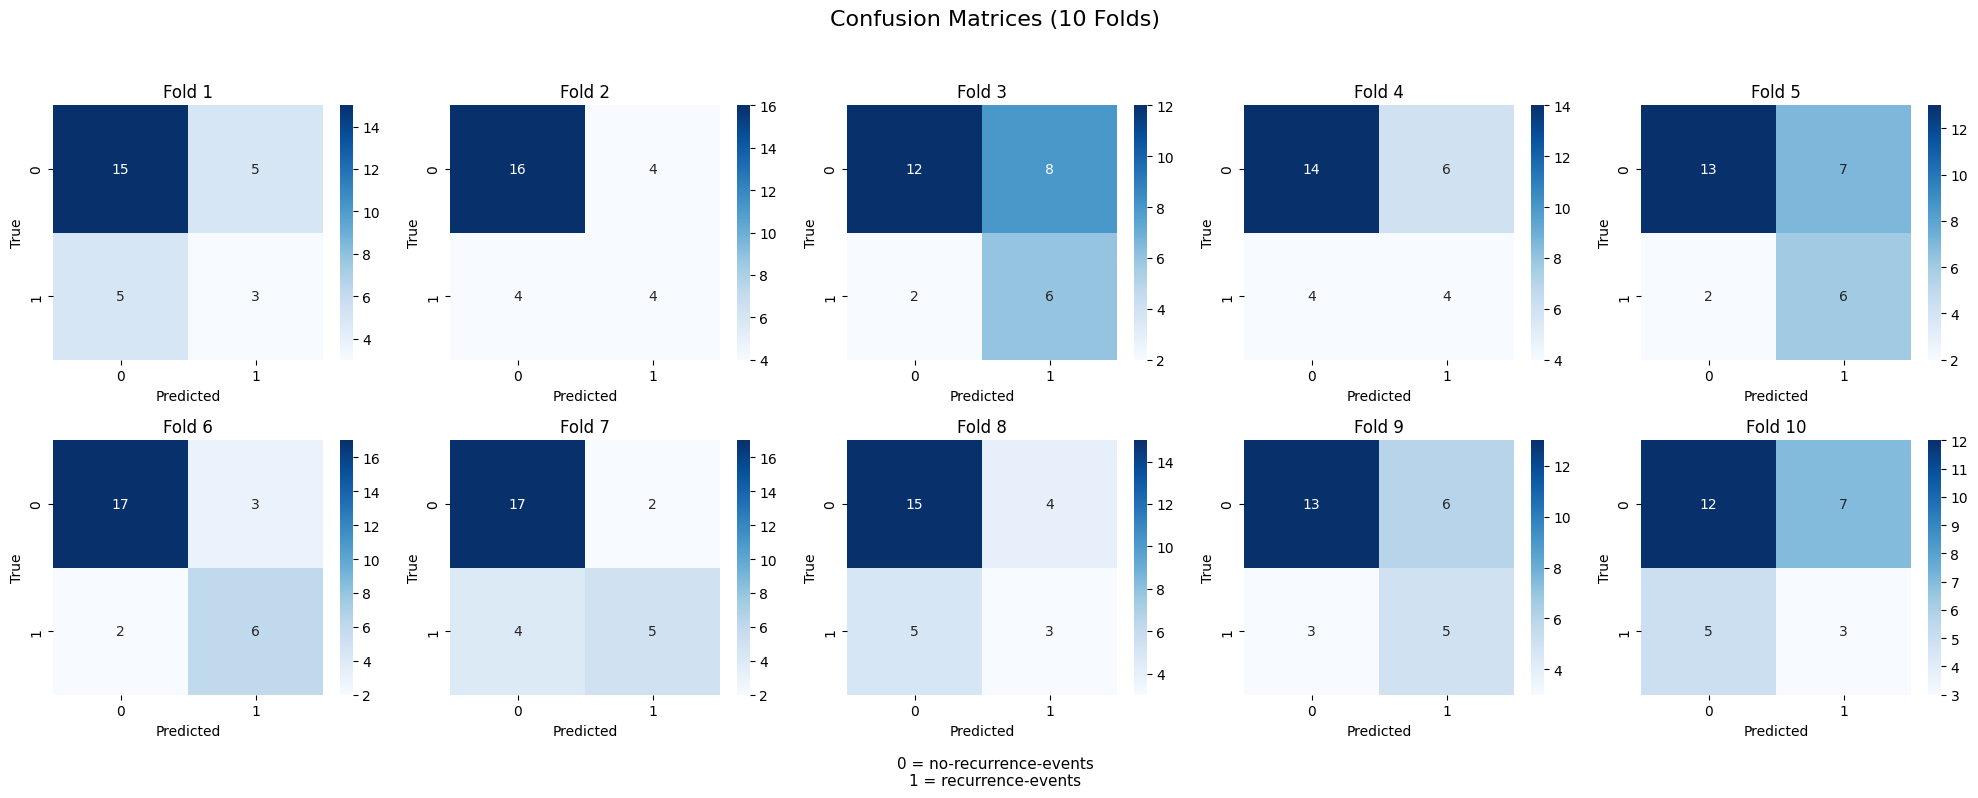

<Figure size 600x500 with 0 Axes>

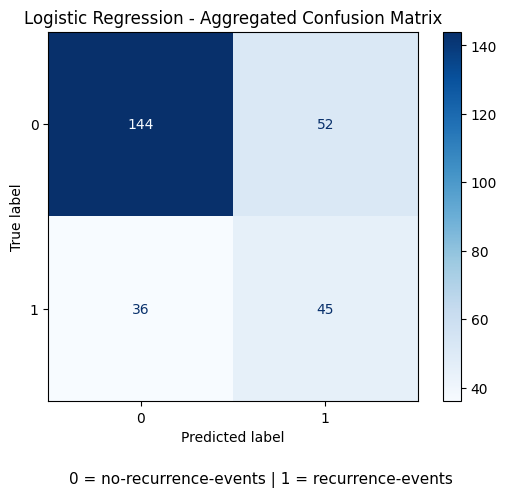

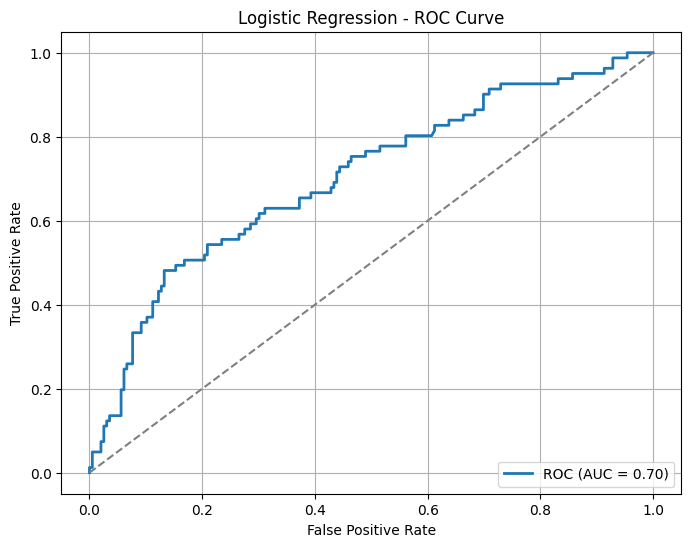

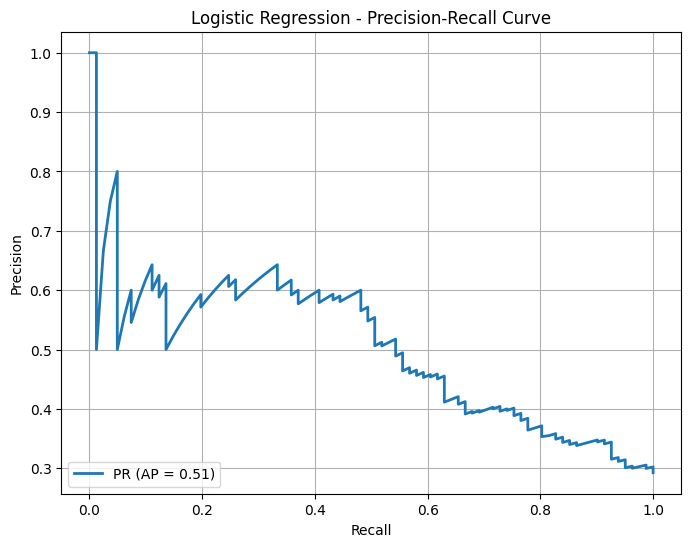


AUC-ROC: 0.703
Average Precision: 0.506


In [12]:
set_seed()

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

lr_metrics = []
lr_conf_matrices = []
lr_y_true_all = []
lr_y_proba_all = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000))
    ])

    grid = GridSearchCV(pipeline, lr_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    lr_y_true_all.extend(y_test)
    lr_y_proba_all.extend(y_proba)
    lr_metrics.append(compute_metrics(y_test, y_pred))
    lr_conf_matrices.append(confusion_matrix(y_test, y_pred))

lr_y_true_all = np.array(lr_y_true_all)
lr_y_proba_all = np.array(lr_y_proba_all)

lr_df_metrics, lr_auc = full_evaluation(
    lr_metrics, lr_conf_matrices, lr_y_true_all, lr_y_proba_all,
    K_FOLDS, CLASS_NAMES, model_name='Logistic Regression'
)

### Deep Neural Network (Keras)

2026-02-14 16:15:04.911220: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Fold 1: F1=0.471, Threshold=0.47
  Fold 2: F1=0.588, Threshold=0.23
  Fold 3: F1=0.640, Threshold=0.52
  Fold 4: F1=0.609, Threshold=0.48
  Fold 5: F1=0.571, Threshold=0.87
  Fold 6: F1=0.632, Threshold=0.45
  Fold 7: F1=0.522, Threshold=0.12
  Fold 8: F1=0.583, Threshold=0.15
  Fold 9: F1=0.615, Threshold=0.74
  Fold 10: F1=0.500, Threshold=0.10


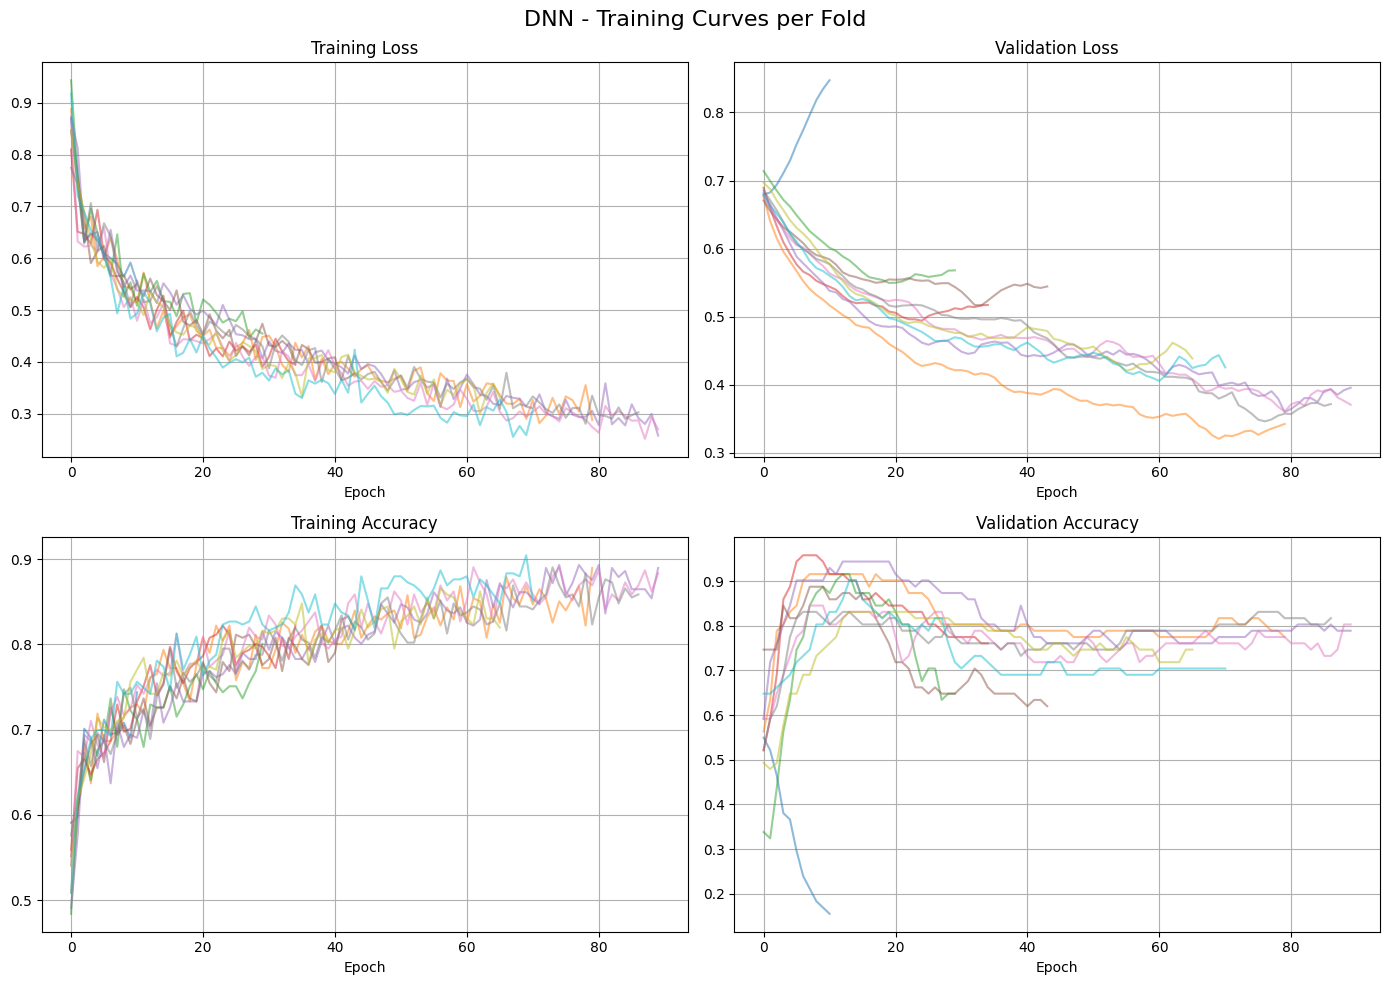

Deep Neural Network - Evaluation Results

Metrics per fold:
 Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 0.357143           0.653846        0.550000          0.326203              0.802198           0.357143             0.264324
 0.750000           0.698830        0.712500          0.704374              0.760234           0.750000             0.754148
 0.678571           0.735294        0.775000          0.674839              0.848739           0.678571             0.689770
 0.678571           0.694872        0.737500          0.667984              0.792674           0.678571             0.693394
 0.785714           0.742424        0.700000          0.714286              0.774892           0.785714             0.775510
 0.750000           0.713904        0.750000          0.721195              0.786096           0.750000             0.759602
 0.607143           0.607143        0.622807          0.594203   

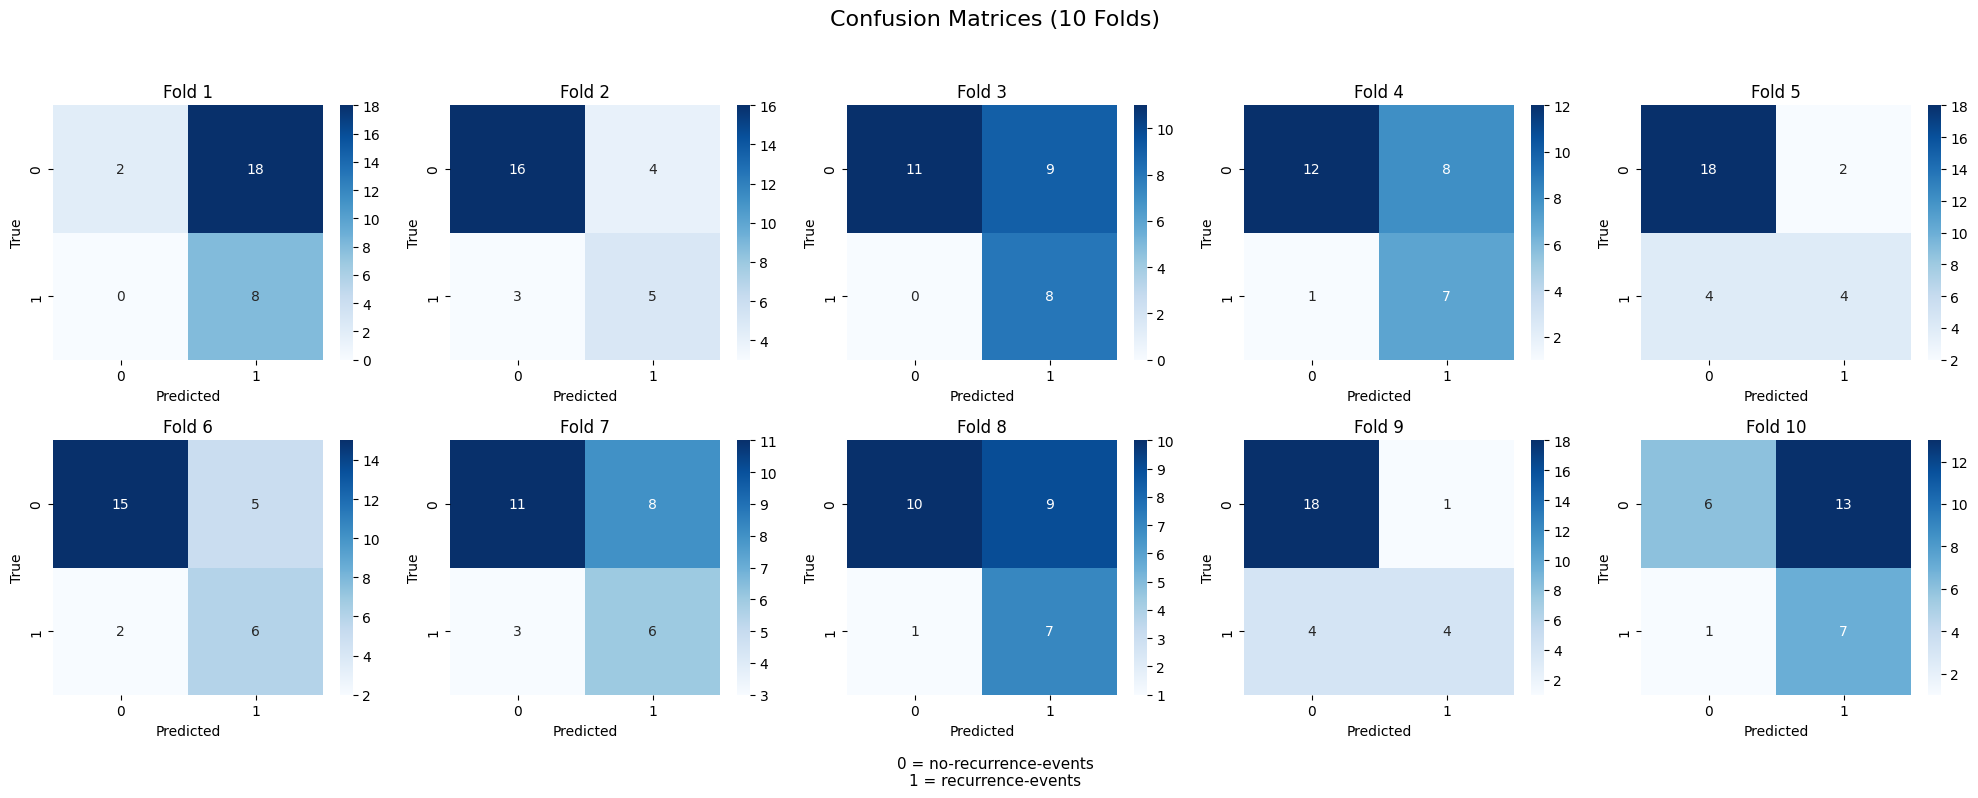

<Figure size 600x500 with 0 Axes>

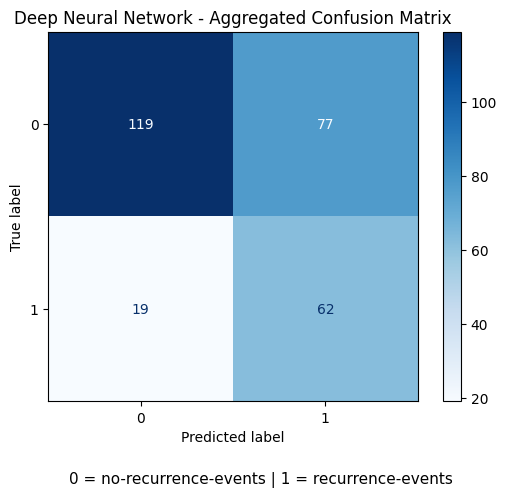

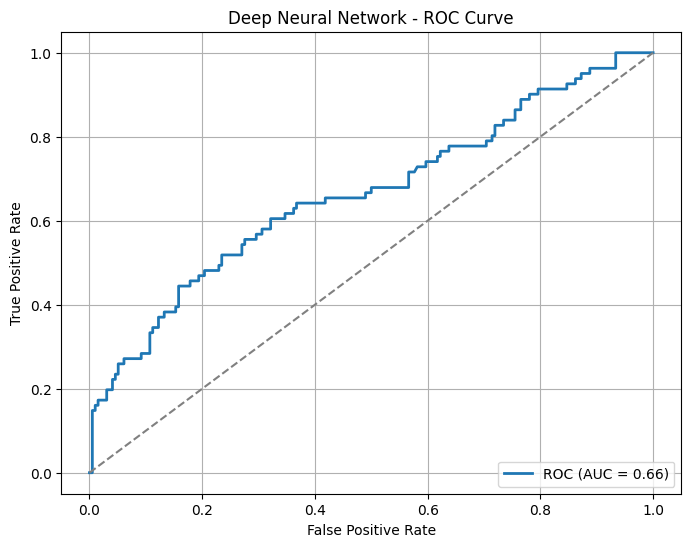

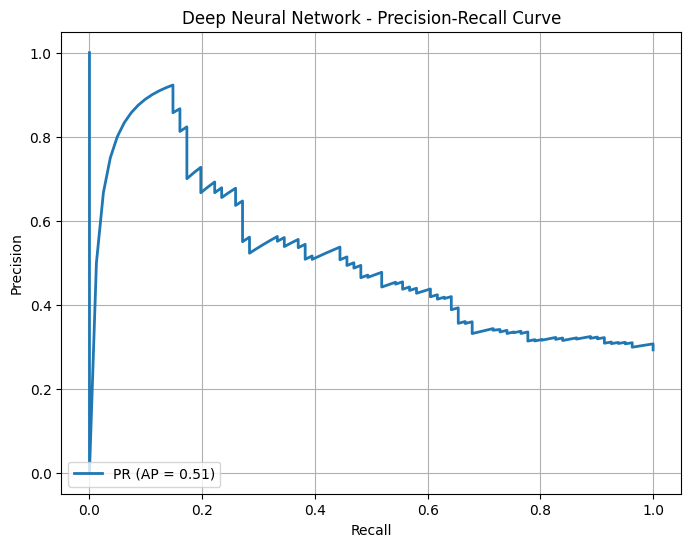


AUC-ROC: 0.663
Average Precision: 0.511


In [13]:
set_seed()

def weighted_binary_crossentropy(pos_weight):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights = y_true * pos_weight + (1. - y_true)
        return tf.reduce_mean(weights * bce)
    return loss

def build_model(hp, input_shape, pos_weight):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(units=hp.Int('units_1', 64, 256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', 32, 128, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=weighted_binary_crossentropy(pos_weight),
        metrics=['accuracy']
    )
    return model

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

dnn_metrics = []
dnn_conf_matrices = []
dnn_y_true_all = []
dnn_y_proba_all = []
dnn_histories = []
best_hp = None

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    set_seed()
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)

    selector = SelectKBest(score_func=mutual_info_classif, k=15)
    X_train_prep = selector.fit_transform(X_train_prep, y_train_fold)
    X_test_prep = selector.transform(X_test_prep)

    sm = SMOTE(random_state=RANDOM_STATE)
    X_train_prep, y_train_fold = sm.fit_resample(X_train_prep, y_train_fold)

    class_weights_array = compute_class_weight(
        class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold
    )
    pos_weight = class_weights_array[1] / class_weights_array[0]
    input_shape = X_train_prep.shape[1]

    if fold == 1:
        def build_for_tuner(hp):
            return build_model(hp, input_shape, pos_weight)

        tuner = kt.RandomSearch(
            hypermodel=build_for_tuner,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=1,
            overwrite=True,
            directory='tuner_dir',
            project_name='dnn_tuning'
        )
        tuner.search(
            X_train_prep, y_train_fold,
            validation_split=0.2, epochs=50,
            callbacks=[EarlyStopping(patience=5)],
            verbose=0
        )
        best_hp = tuner.get_best_hyperparameters(1)[0]

    model = build_model(best_hp, input_shape, pos_weight)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train_prep, y_train_fold,
        epochs=100, batch_size=32,
        validation_split=0.2, verbose=0,
        callbacks=[es]
    )
    dnn_histories.append(history.history)

    y_pred_prob = model.predict(X_test_prep, verbose=0).flatten()

    # Ricerca soglia ottimale
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_f1, best_thresh = 0, 0.5
    for t in thresholds:
        y_temp = (y_pred_prob > t).astype(int)
        f1_val = f1_score(y_test_fold, y_temp, zero_division=0)
        if f1_val > best_f1:
            best_f1 = f1_val
            best_thresh = t

    y_pred = (y_pred_prob > best_thresh).astype(int)

    dnn_y_true_all.extend(y_test_fold)
    dnn_y_proba_all.extend(y_pred_prob)
    dnn_metrics.append(compute_metrics(y_test_fold, y_pred))
    dnn_conf_matrices.append(confusion_matrix(y_test_fold, y_pred))

    print(f'  Fold {fold}: F1={best_f1:.3f}, Threshold={best_thresh:.2f}')

dnn_y_true_all = np.array(dnn_y_true_all)
dnn_y_proba_all = np.array(dnn_y_proba_all)

# Training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for hist in dnn_histories:
    axes[0, 0].plot(hist['loss'], alpha=0.5)
    axes[0, 1].plot(hist['val_loss'], alpha=0.5)
    axes[1, 0].plot(hist['accuracy'], alpha=0.5)
    axes[1, 1].plot(hist['val_accuracy'], alpha=0.5)
titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.grid(True)
plt.suptitle('DNN - Training Curves per Fold', fontsize=16)
plt.tight_layout()
plt.show()

dnn_df_metrics, dnn_auc = full_evaluation(
    dnn_metrics, dnn_conf_matrices, dnn_y_true_all, dnn_y_proba_all,
    K_FOLDS, CLASS_NAMES, model_name='Deep Neural Network'
)

### Random forest

Random Forest - Evaluation Results

Metrics per fold:
 Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 0.571429           0.511111        0.512500          0.508772              0.601587           0.571429             0.583960
 0.821429           0.900000        0.687500          0.717172              0.857143           0.821429             0.790765
 0.678571           0.595238        0.587500          0.590244              0.666667           0.678571             0.671777
 0.678571           0.569565        0.550000          0.549195              0.642236           0.678571             0.652696
 0.821429           0.785714        0.762500          0.772358              0.816327           0.821429             0.817654
 0.857143           0.848485        0.787500          0.809524              0.854978           0.857143             0.850340
 0.750000           0.865385        0.611111          0.604040         

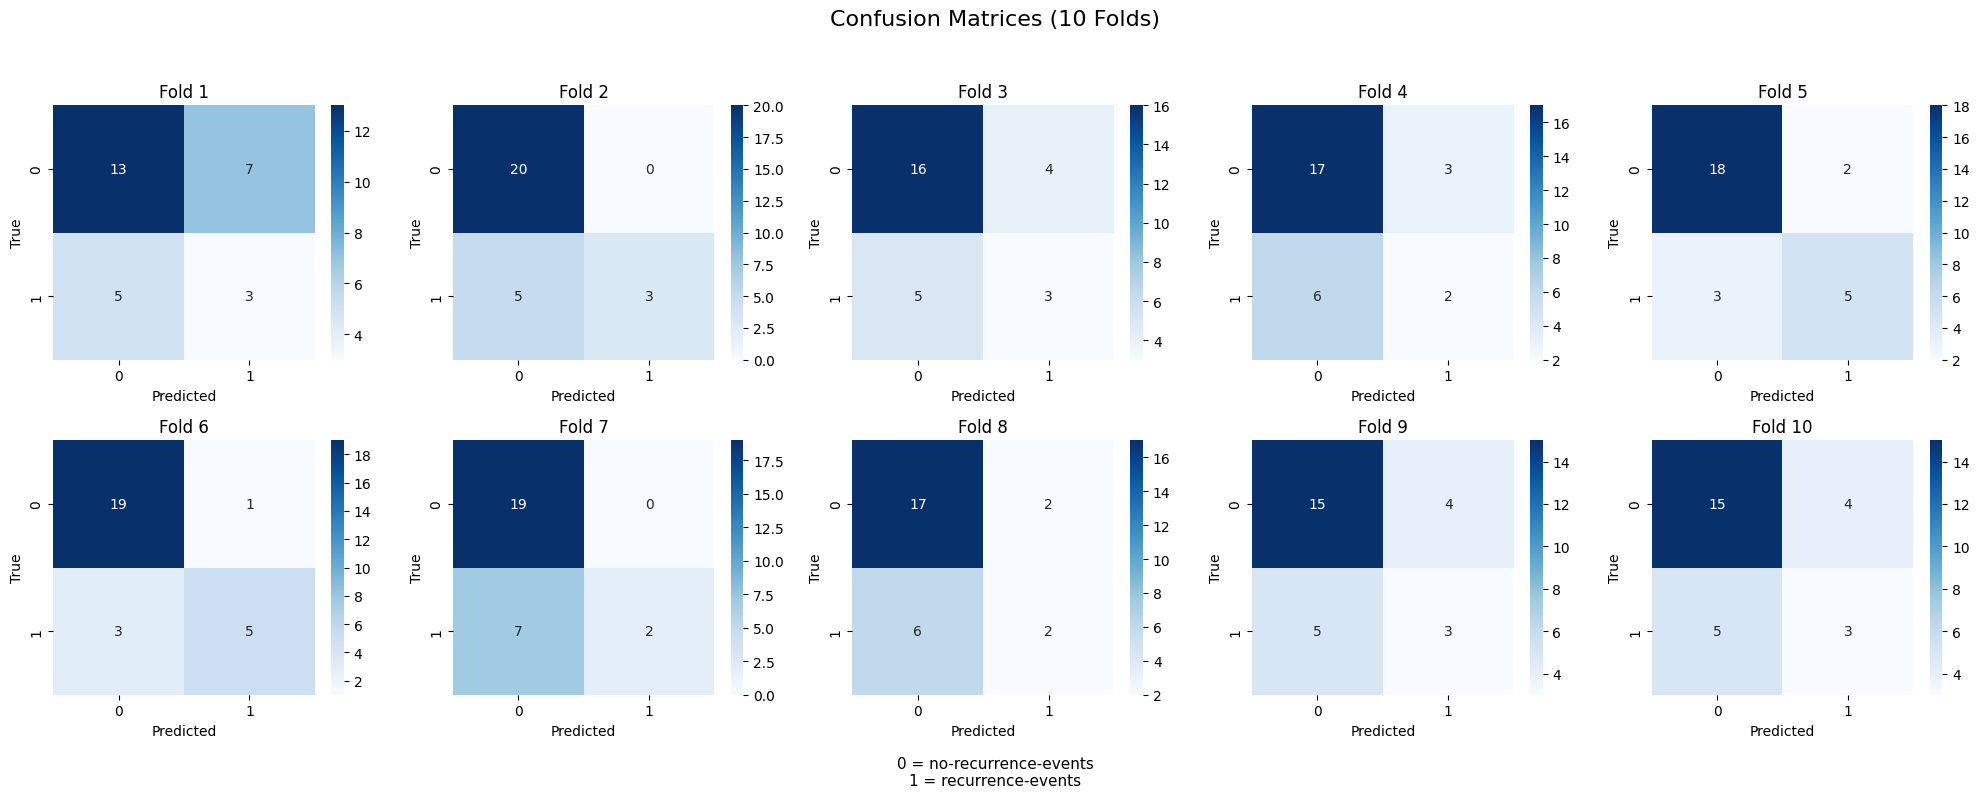

<Figure size 600x500 with 0 Axes>

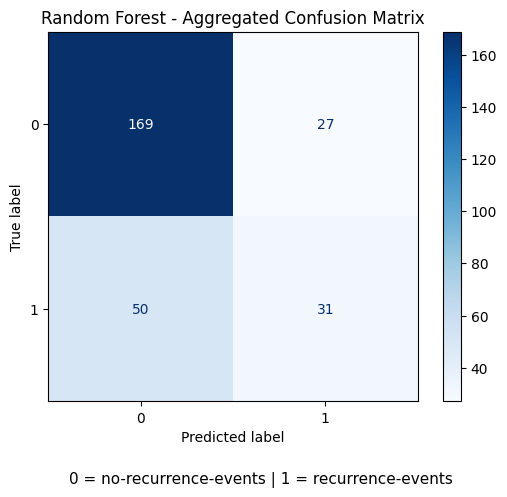

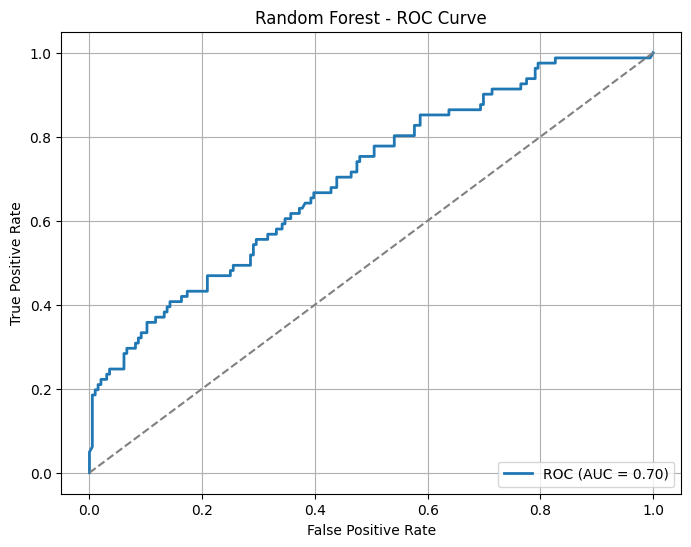

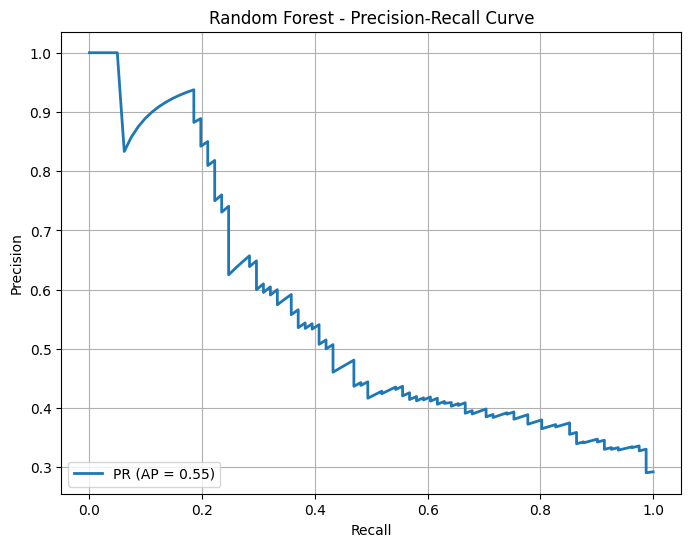


AUC-ROC: 0.699
Average Precision: 0.553


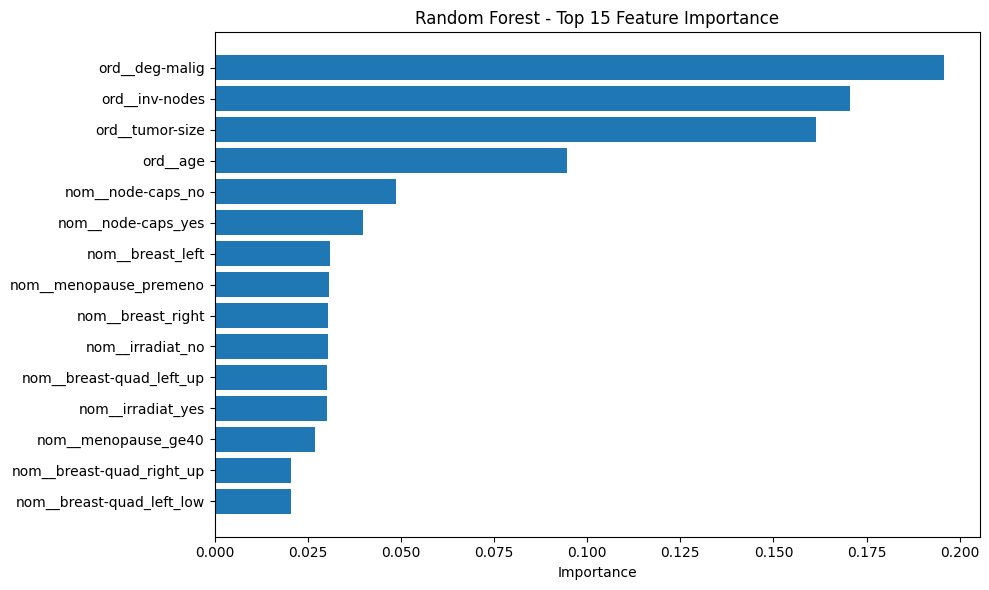

In [14]:
set_seed()

rf_param_grid = {
    'smote__k_neighbors': [3, 5],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

rf_metrics = []
rf_conf_matrices = []
rf_y_true_all = []
rf_y_proba_all = []
rf_importances = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', RandomForestClassifier(
            random_state=RANDOM_STATE, class_weight='balanced'
        ))
    ])

    grid = GridSearchCV(pipeline, rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    rf_y_true_all.extend(y_test)
    rf_y_proba_all.extend(y_proba)
    rf_metrics.append(compute_metrics(y_test, y_pred))
    rf_conf_matrices.append(confusion_matrix(y_test, y_pred))
    rf_importances.append(best_model.named_steps['classifier'].feature_importances_)

rf_y_true_all = np.array(rf_y_true_all)
rf_y_proba_all = np.array(rf_y_proba_all)

rf_df_metrics, rf_auc = full_evaluation(
    rf_metrics, rf_conf_matrices, rf_y_true_all, rf_y_proba_all,
    K_FOLDS, CLASS_NAMES, model_name='Random Forest'
)

# Feature importance media
mean_importances = np.mean(rf_importances, axis=0)
feature_names_out = best_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': mean_importances
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'].values, align='center')
plt.yticks(range(len(importance_df)), importance_df['Feature'].values)
plt.xlabel('Importance')
plt.title('Random Forest - Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Support Vector Machine

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM params: {'classifier__C': np.float64(2.5519126744095186), 'classifier__gamma': np.float64(0.10799142699330445)}
SVM (sigmoid) - Evaluation Results

Metrics per fold:
 Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 0.714286           0.666667        0.687500          0.672515              0.738095           0.714286             0.722640
 0.750000           0.698830        0.712500          0.704374              0.760234           0.750000             0.754148
 0.750000           0.735897        0.787500          0.733333              0.820513           0.750000             0.761905
 0.642857           0.588889        0.600000          0.590643              0.669841           0.642857             0.653300
 0.607143           0.623077        0.650000          0.594203              0.718681           0.607143             0.625259
 0.714286    

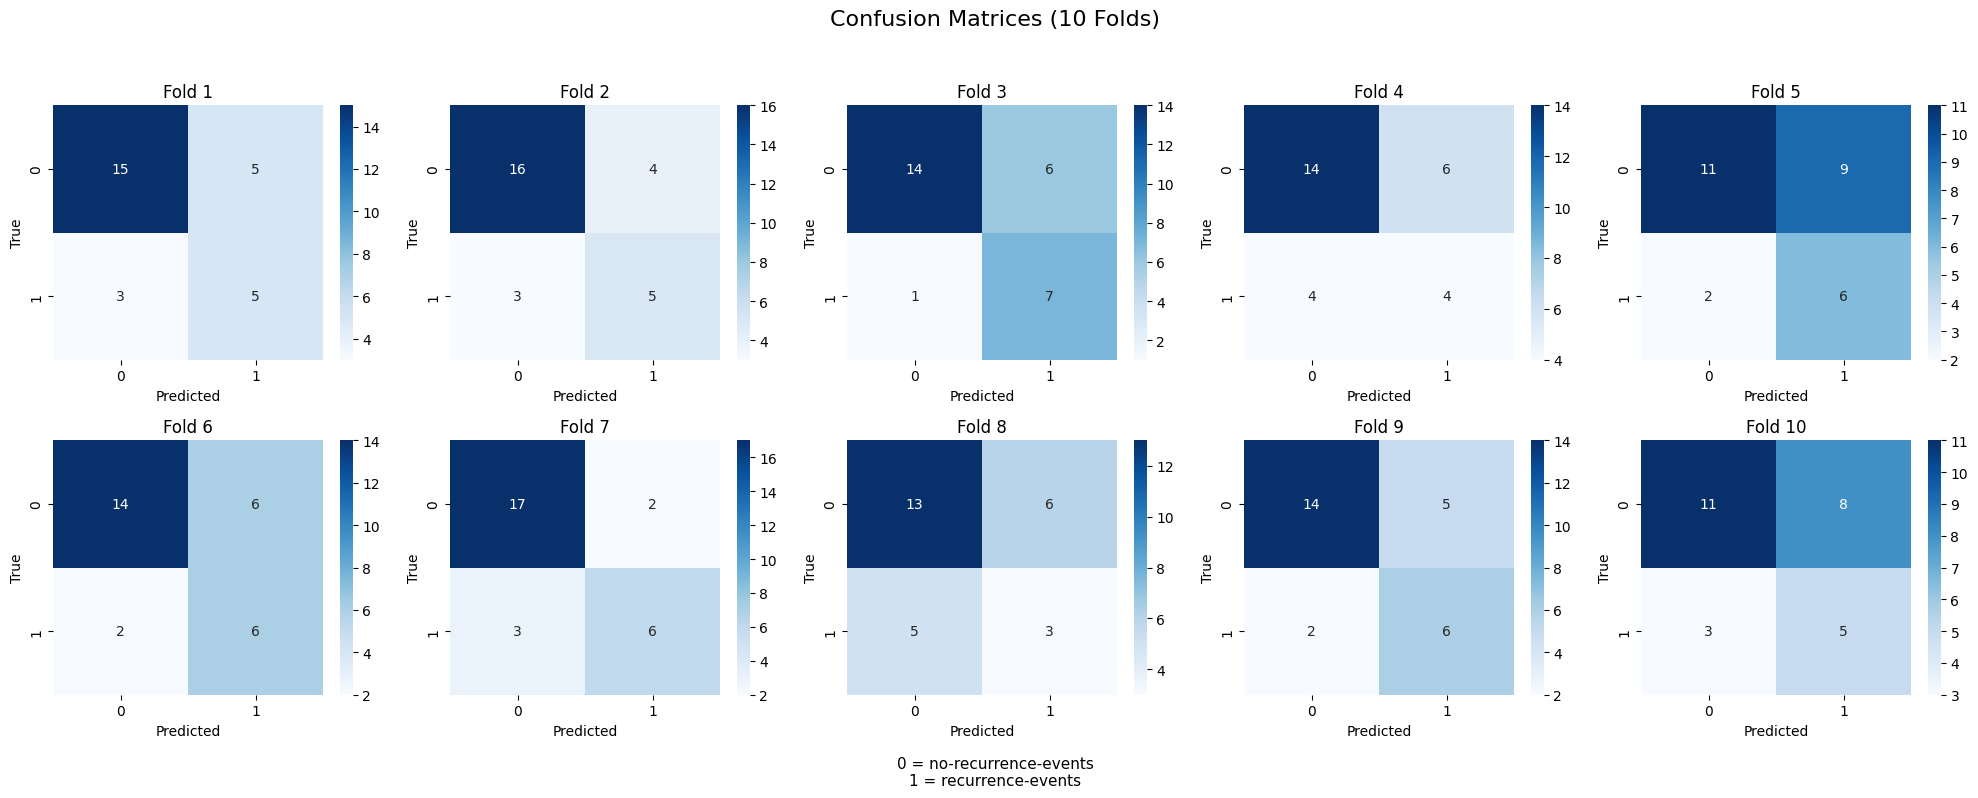

<Figure size 600x500 with 0 Axes>

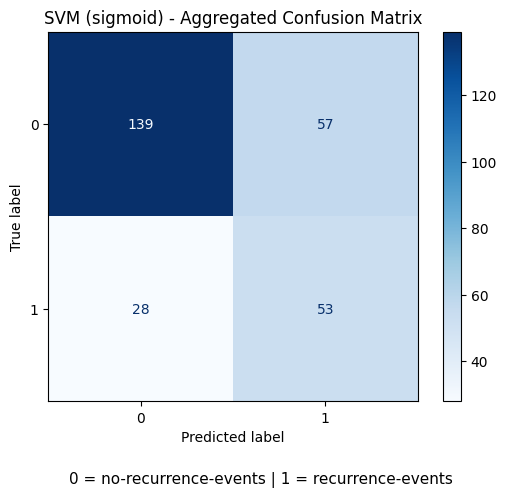

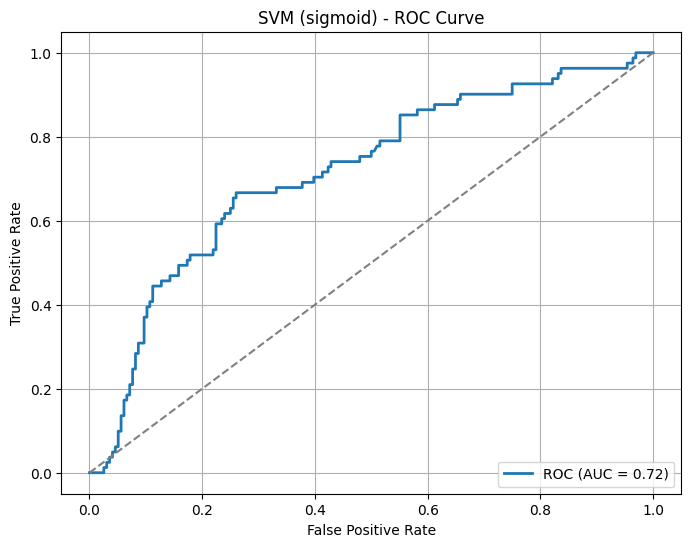

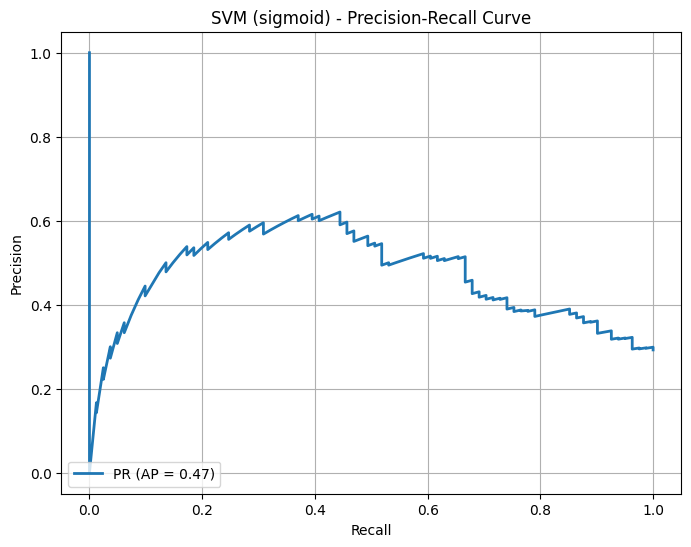


AUC-ROC: 0.717
Average Precision: 0.470


In [17]:
set_seed()

svm_param_distributions = {
    'classifier__C': uniform(loc=0.01, scale=100),
    'classifier__gamma': uniform(loc=1e-4, scale=1)
}

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

svm_metrics = []
svm_conf_matrices = []
svm_y_true_all = []
svm_y_proba_all = []

svm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SVC(kernel='sigmoid', class_weight='balanced', probability=True))
])

# Hyperparameter search su tutto il training set
X_train_full, X_test_hold, y_train_full, y_test_hold = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_distributions,
    n_iter=60,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train_full, y_train_full)
best_svm_params = random_search.best_params_
print(f'Best SVM params: {best_svm_params}')

# Cross-validation con i migliori parametri
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_pipeline = clone(svm_pipeline)
    fold_pipeline.set_params(**best_svm_params)
    fold_pipeline.fit(X_train, y_train)

    y_pred = fold_pipeline.predict(X_test)
    y_proba = fold_pipeline.predict_proba(X_test)[:, 1]

    svm_y_true_all.extend(y_test)
    svm_y_proba_all.extend(y_proba)
    svm_metrics.append(compute_metrics(y_test, y_pred))
    svm_conf_matrices.append(confusion_matrix(y_test, y_pred))

svm_y_true_all = np.array(svm_y_true_all)
svm_y_proba_all = np.array(svm_y_proba_all)

svm_df_metrics, svm_auc = full_evaluation(
    svm_metrics, svm_conf_matrices, svm_y_true_all, svm_y_proba_all,
    K_FOLDS, CLASS_NAMES, model_name='SVM (sigmoid)'
)

### XGBoost

XGBoost - Evaluation Results

Metrics per fold:
 Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 0.714286           0.666667        0.687500          0.672515              0.738095           0.714286             0.722640
 0.750000           0.713333        0.600000          0.604040              0.733333           0.750000             0.707071
 0.714286           0.636364        0.612500          0.619048              0.694805           0.714286             0.700680
 0.714286           0.636364        0.612500          0.619048              0.694805           0.714286             0.700680
 0.785714           0.737500        0.737500          0.737500              0.785714           0.785714             0.785714
 0.714286           0.650000        0.650000          0.650000              0.714286           0.714286             0.714286
 0.750000           0.865385        0.611111          0.604040              0

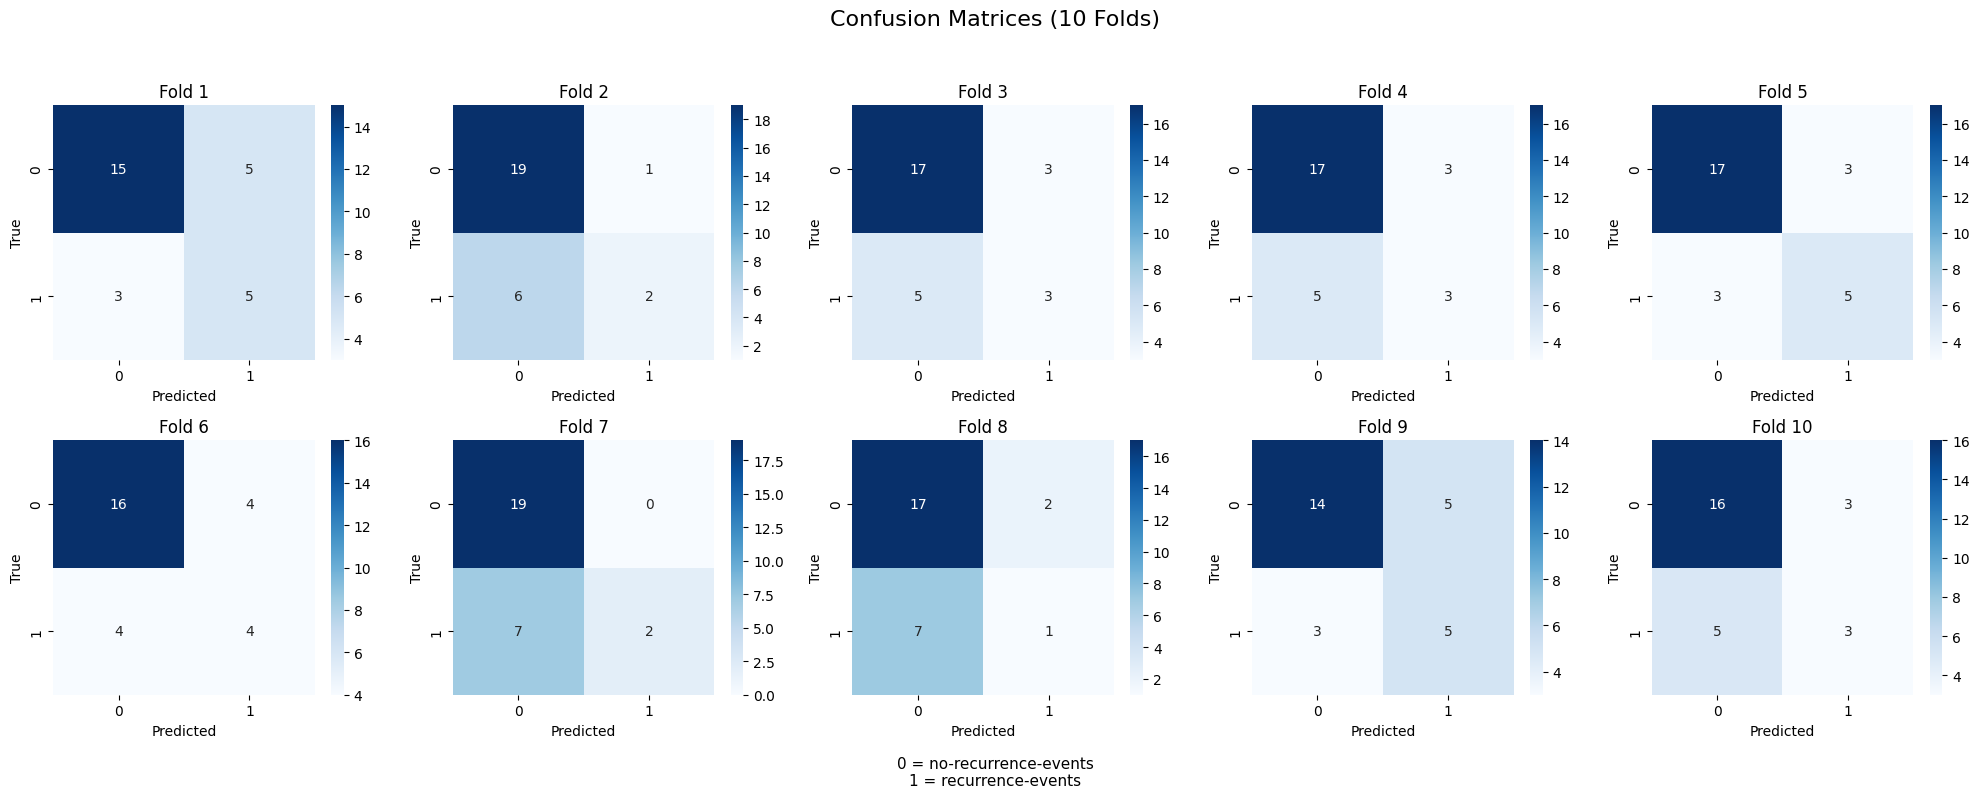

<Figure size 600x500 with 0 Axes>

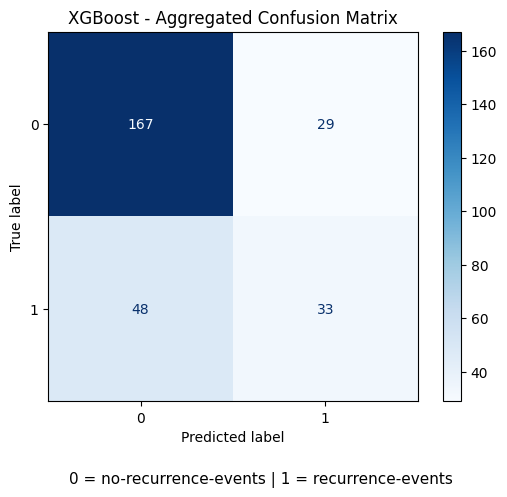

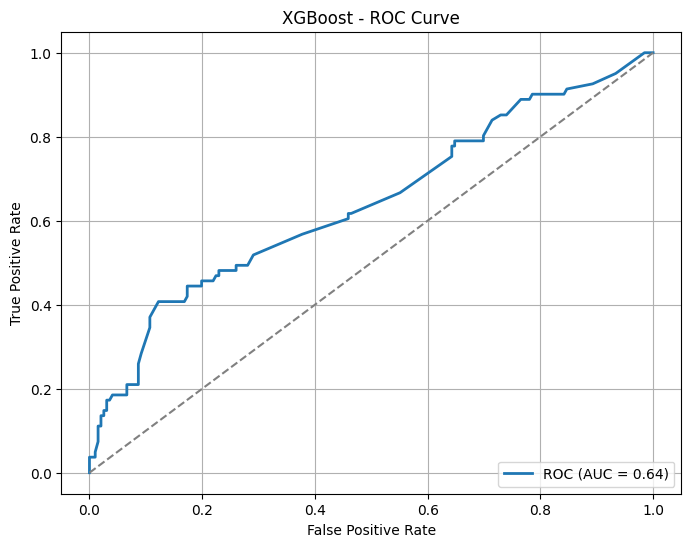

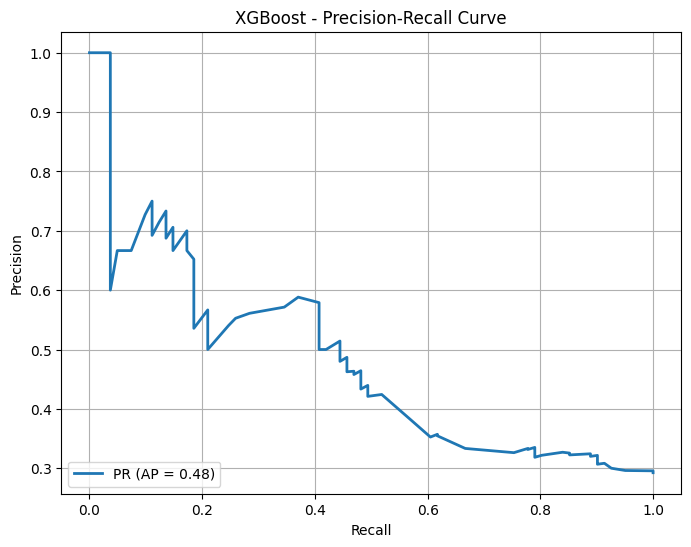


AUC-ROC: 0.641
Average Precision: 0.478


In [18]:
set_seed()

xgb_param_grid = {
    'feature_selection__k': [5, 7, 9],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.1]
}

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

xgb_metrics = []
xgb_conf_matrices = []
xgb_y_true_all = []
xgb_y_proba_all = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=chi2_feat)),
        ('smote', SMOTEENN(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(
            eval_metric='logloss', random_state=RANDOM_STATE, use_label_encoder=False
        ))
    ])

    grid = GridSearchCV(pipeline, xgb_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    xgb_y_true_all.extend(y_test)
    xgb_y_proba_all.extend(y_proba)
    xgb_metrics.append(compute_metrics(y_test, y_pred))
    xgb_conf_matrices.append(confusion_matrix(y_test, y_pred))

xgb_y_true_all = np.array(xgb_y_true_all)
xgb_y_proba_all = np.array(xgb_y_proba_all)

xgb_df_metrics, xgb_auc = full_evaluation(
    xgb_metrics, xgb_conf_matrices, xgb_y_true_all, xgb_y_proba_all,
    K_FOLDS, CLASS_NAMES, model_name='XGBoost'
)

### Saving data

In [19]:
all_results = {
    'Logistic Regression': {
        'metrics': lr_metrics,
        'y_true': lr_y_true_all,
        'y_proba': lr_y_proba_all
    },
    'DNN (Keras)': {
        'metrics': dnn_metrics,
        'y_true': dnn_y_true_all,
        'y_proba': dnn_y_proba_all
    },
    'Random Forest': {
        'metrics': rf_metrics,
        'y_true': rf_y_true_all,
        'y_proba': rf_y_proba_all
    },
    'SVM (sigmoid)': {
        'metrics': svm_metrics,
        'y_true': svm_y_true_all,
        'y_proba': svm_y_proba_all
    },
    'XGBoost': {
        'metrics': xgb_metrics,
        'y_true': xgb_y_true_all,
        'y_proba': xgb_y_proba_all
    }
}

with open('../data/model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
